In [1]:
!pwd

/home/pvasquh/Proyectos


# Estimating order times

Cornershop has operations in several cities and countries, delivering thousands of orders every day. In order to deliver these orders on time we depend on good estimations of how much time the shopper needs to complete the order.

**Objective**: Predict total duration of an order based on features regarding order, products, shopper and store information

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from haversine import haversine
import datetime
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier

%config InlineBackend.figure_format='retina'
%matplotlib inline

### Order information

In [3]:
order_products = pd.read_csv('data/order_products.csv')
order_products.head(5)

,order_id,product_id,quantity,buy_unit
0,47099653730fb1b76537fc10ad876255,c1244453d731c77416cb4766e3bd76cb,1.0,UN
1,689d8866915acf87e851c2591a23a82f,43cc2b100bec640fe563cd16f2db669f,1.0,KG
2,f26d16bf6f38c9e31d0be877f4013a9e,b8f880759d014134e272d881d49989a2,1.0,UN
3,161ccc896835ab41761b0e726becb6b1,dbc062b9bef805d27a6f4bea7edfe1f1,1.0,UN
4,4713deca10bb5db98fae150b52d61fc0,93a060f269bb569398921100f84c519a,2.0,UN


In [4]:
order_products.shape

(198500, 4)

In [5]:
order_products.order_id.nunique()

9978

In [6]:
order_products.product_id.nunique()

15422

We have product information from 9,978 orders in total. There are 15,422 total products in this dataset.

In [7]:
order_products.buy_unit.unique()

array(['UN', 'KG'], dtype=object)

Products can be measured in units or kilograms.

In [8]:
orders = pd.read_csv('data/orders.csv')
orders.head()

,order_id,lat,lng,promised_time,on_demand,shopper_id,store_branch_id,total_minutes
0,e750294655c2c7c34d83cc3181c09de4,-33.501675,-70.579369,2019-10-18 20:48:00+00:00,True,e63bc83a1a952fa2b3cc9d558fb943cf,65ded5353c5ee48d0b7d48c591b8f430,67.684264
1,6581174846221cb6c467348e87f57641,-33.440584,-70.556283,2019-10-19 01:00:00+00:00,False,195f9e9d84a4ba9033c4b6a756334d8b,45fbc6d3e05ebd93369ce542e8f2322d,57.060632
2,3a226ea48debc0a7ae9950d5540f2f34,-32.987022,-71.544842,2019-10-19 14:54:00+00:00,True,a5b9ddc0d82e61582fca19ad43dbaacb,07563a3fe3bbe7e3ba84431ad9d055af,NaN
3,7d2ed03fe4966083e74b12694b1669d8,-33.328075,-70.512659,2019-10-18 21:47:00+00:00,True,d0b3f6bf7e249e5ebb8d3129341773a2,f1748d6b0fd9d439f71450117eba2725,52.067742
4,b4b2682d77118155fe4716300ccf7f39,-33.403239,-70.564020,2019-10-19 20:00:00+00:00,False,5c5199ce02f7b77caa9c2590a39ad27d,1f0e3dad99908345f7439f8ffabdffc4,140.724822


In [9]:
orders.shape

(10000, 8)

We have data for 10,000 orders, which means we will have missing product values for 22 orders. We will only work with orders for which we have product information.

In [10]:
orders_with_info_ids = order_products.order_id.unique()

In [11]:
orders_with_info_ids.shape

(9978,)

In [12]:
orders = orders[orders.order_id.isin(orders_with_info_ids)]

In [13]:
orders.shape

(9978, 8)

### Exploring the target values

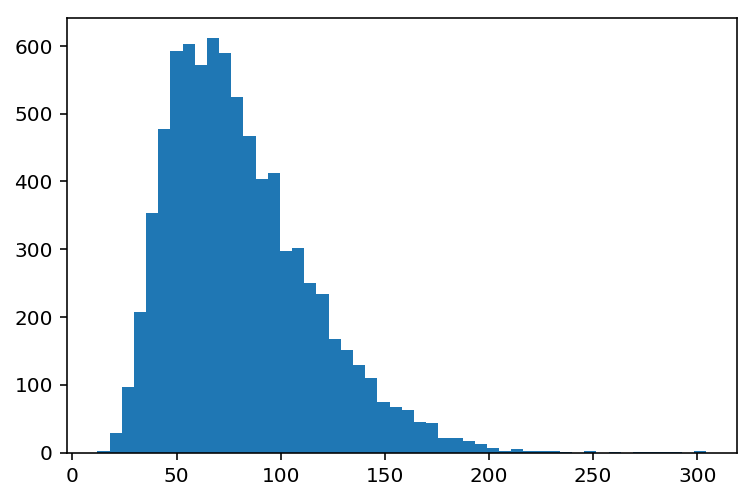

In [14]:
orders.total_minutes.hist(grid=False, bins=50)

Initially, one might think that since there are small and large orders, the total time distribution could be bimodal. However, a simple histogram shows that the majority of orders take less than two hours to complete.

### Determining order size

In [15]:
order_products[order_products.buy_unit=='UN'].quantity.describe()

count    180654.000000
mean          1.908333
std           1.964279
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         100.000000
Name: quantity, dtype: float64

In [16]:
order_products[order_products.buy_unit=='KG'].quantity.describe()

count    17846.000000
mean         0.971702
std          0.728834
min          0.055000
25%          0.498000
50%          0.835000
75%          1.200000
max         16.250000
Name: quantity, dtype: float64

Since we have two units of measure for the products within a basket, we must find a way to determine how many kg of a product equals one unit. As we have no information regarding the size of the portions, we will use the median of the kilograms ordered for each product.

In [17]:
product_median = order_products.groupby('product_id').quantity.median()

In [18]:
order_products = pd.merge(order_products, product_median, on='product_id', how='left', suffixes=('', '_median'))

In [19]:
order_products['quantity_conv'] = order_products.apply(lambda row: (row.quantity/row.quantity_median) if row.buy_unit=='KG' else row.quantity, axis=1)
order_products.head(10)

,order_id,product_id,quantity,buy_unit,quantity_median,quantity_conv
0,47099653730fb1b76537fc10ad876255,c1244453d731c77416cb4766e3bd76cb,1.000,UN,1.00,1.00
1,689d8866915acf87e851c2591a23a82f,43cc2b100bec640fe563cd16f2db669f,1.000,KG,1.00,1.00
2,f26d16bf6f38c9e31d0be877f4013a9e,b8f880759d014134e272d881d49989a2,1.000,UN,1.00,1.00
3,161ccc896835ab41761b0e726becb6b1,dbc062b9bef805d27a6f4bea7edfe1f1,1.000,UN,1.00,1.00
4,4713deca10bb5db98fae150b52d61fc0,93a060f269bb569398921100f84c519a,2.000,UN,2.00,2.00
5,742c8318bd4b691ef21517372e12eb14,3692fe3fc98b55a7f41b70e24c5e70f1,1.000,UN,1.00,1.00
6,4bf1d742d2aaa747c8e42074306776c6,af43ffd0ff63a72e50e7340a382bcfb6,1.000,UN,1.00,1.00
7,a8b56b2aba8e0c2609b1e70fff2c1951,bdcc4590896a0d0b419d0388fd16a859,0.885,KG,1.18,0.75
8,63d745ef282dfeee0a89b5c8e4e79acb,07baf42dfefb6ed87312007dddab125e,1.000,UN,1.00,1.00
9,bea1786439523ef6973ec8395231e713,f387d33f0f968f1005e9ef45b66266c6,1.000,UN,2.00,1.00


In [20]:
order_products.quantity_conv.describe()

count    198500.000000
mean          1.838652
std           1.897635
min           0.080000
25%           1.000000
50%           1.000000
75%           2.000000
max         100.000000
Name: quantity_conv, dtype: float64

The majority of products are bought in less than two units. Now we can calculate the total size of the basket.

In [21]:
order_size = order_products.groupby('order_id')['quantity_conv'].sum()

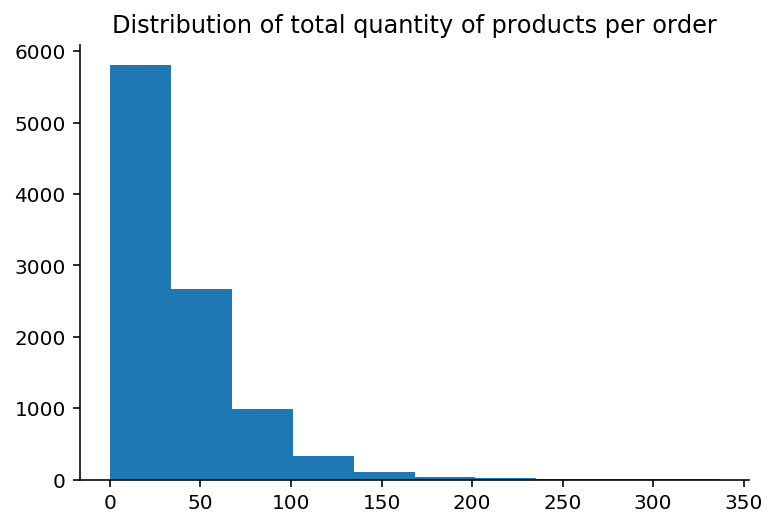

In [22]:
order_size.hist(grid=False)
plt.title('Distribution of total quantity of products per order')

sns.despine()
plt.show()

We wonder if there is a relationship between order size and total duration.

In [23]:
orders = pd.merge(orders, order_size, on='order_id', how='left')

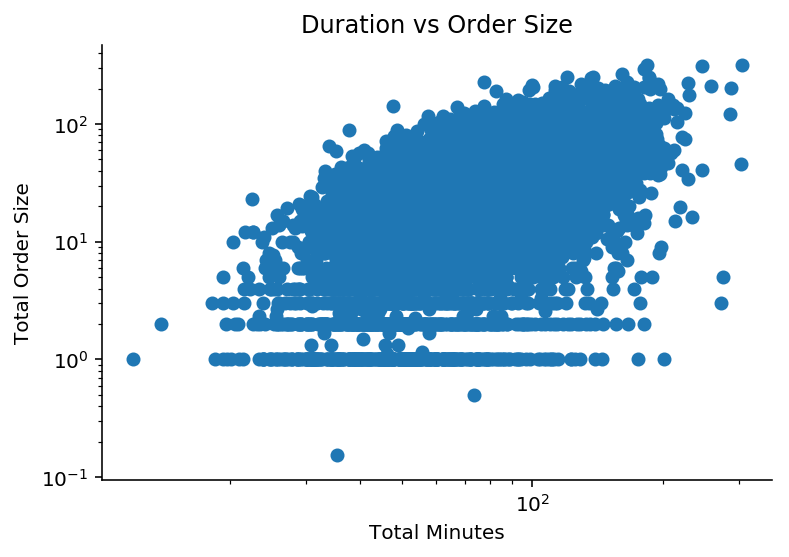

In [24]:
plt.scatter(orders.total_minutes, orders.quantity_conv)
plt.xlabel('Total Minutes')
plt.ylabel('Total Order Size')
plt.yscale('log')
plt.xscale('log')
plt.title('Duration vs Order Size')
sns.despine()
plt.show()

In [25]:
#order_products = order_products[~order_products.order_id.isin(orders_predict_ids)]

In [26]:
orders['product_n'] = order_products.groupby('order_id')['product_id'].count().values

In [27]:
orders['product_metcalfe'] = orders['product_n'] ** 2

### Analyzing Order Times

In [28]:
orders.promised_time.dtype

dtype('O')

In [29]:
orders['promised_time'] = pd.to_datetime(orders.promised_time)
orders['promised_time_hour'] = orders.promised_time.dt.hour

In [30]:
orders['order_time'] = orders.promised_time - datetime.timedelta(minutes=90)
orders['order_time_hour'] = orders.order_time.dt.hour

It would be of interest to determine how many times we are able to deliver within the promised time. For this, we need to determine the time the order was placed. We will assume that promised time is a maximum of 90 minutes after the order was done.

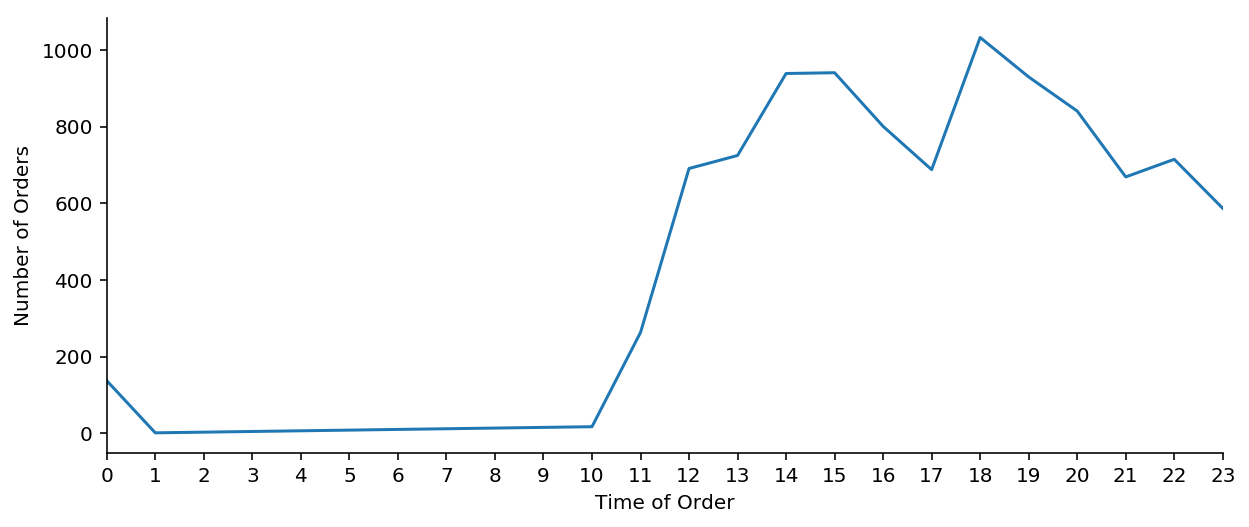

In [31]:
orders.order_time_hour.value_counts().sort_index().plot(figsize=(10,4))
plt.xticks(range(0,24))
plt.xlabel('Time of Order')
plt.ylabel('Number of Orders')
sns.despine()

Ordering time has its peaks between 14:00 and 15:00 and then at 18:00. Is there any relation between ordering times and total minutes?

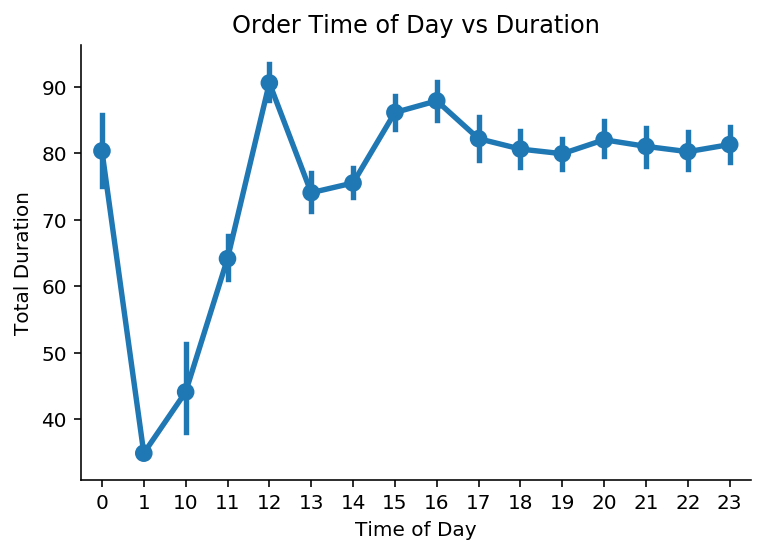

In [32]:
sns.pointplot(data=orders, x='order_time_hour', y='total_minutes')
plt.xlabel('Time of Day')
plt.ylabel('Total Duration')

plt.title('Order Time of Day vs Duration')
sns.despine()
plt.show()

In [33]:
orders['order_time_dayofweek'] = orders.order_time.dt.dayofweek

In [34]:
orders.order_time_dayofweek.unique()

array([4, 5])

In [35]:
orders['is_weekday'] = np.where(orders['order_time_dayofweek']<5, 1, 0)

In [36]:
orders['is_weekend'] = np.where(orders['order_time_dayofweek']>=5, 1, 0)

In [37]:
orders['month'] = orders.order_time.dt.month

In [38]:
orders['dayofmonth'] = orders.order_time.dt.days_in_month

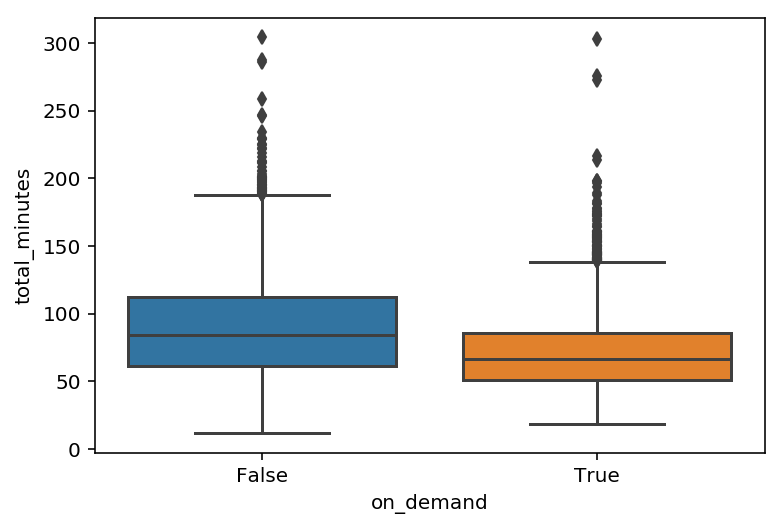

In [39]:
sns.boxplot(x=orders["on_demand"], y=orders["total_minutes"] )

#### Distance order-shop

##### Shortest path

In [41]:
store_branch = pd.read_csv('data/storebranch.csv')
store_branch.head()

,store_branch_id,store_id,lat,lng
0,aff1621254f7c1be92f64550478c56e6,92cc227532d17e56e07902b254dfad10,-33.422497,-70.609231
1,56352739f59643540a3a6e16985f62c7,0336dcbab05b9d5ad24f4333c7658a0e,-33.385484,-70.555579
2,7d04bbbe5494ae9d2f5a76aa1c00fa2f,9bf31c7ff062936a96d3c8bd1f8f2ff3,-33.416579,-70.565224
3,2b24d495052a8ce66358eb576b8912c8,c4ca4238a0b923820dcc509a6f75849b,-33.512578,-70.655952
4,5487315b1286f907165907aa8fc96619,d82c8d1619ad8176d665453cfb2e55f0,-33.347645,-70.542229


In [42]:
orders['destination_point'] = orders[['lat', 'lng']].apply(tuple, axis=1)
store_branch['origin_point'] = store_branch[['lat', 'lng']].apply(tuple, axis=1)

In [43]:
order_store = pd.merge(orders[['order_id', 'store_branch_id', 'destination_point']], store_branch[['store_id', 'store_branch_id', 'origin_point']], on='store_branch_id', how='left')

In [44]:
orders['distance'] = order_store.apply(lambda x: haversine(x.origin_point, x.destination_point), axis=1)

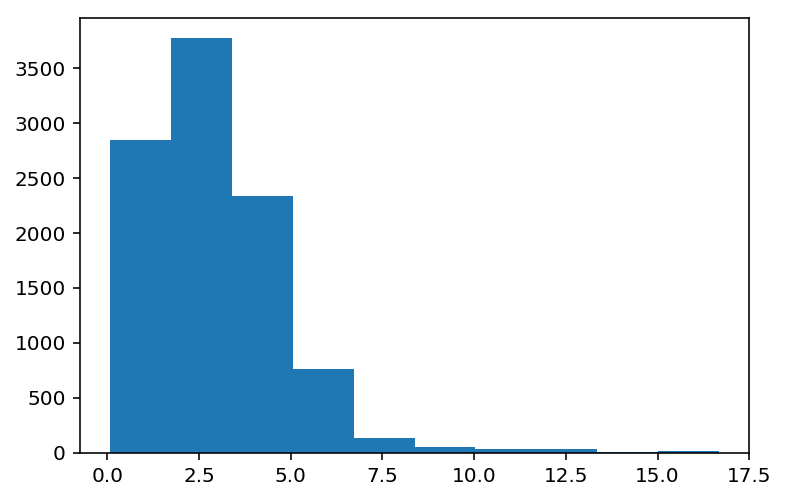

In [45]:
orders.distance.hist(grid=False)

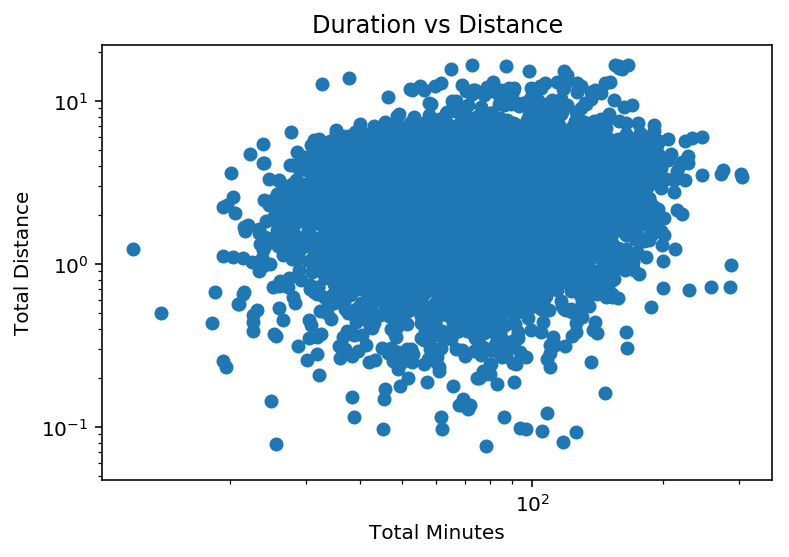

In [46]:
plt.scatter(orders.total_minutes, orders.distance)
plt.xlabel('Total Minutes')
plt.ylabel('Total Distance')
plt.yscale('log')
plt.xscale('log')
plt.title('Duration vs Distance')
plt.show()

In [47]:
store_branch_dummies = order_store.set_index('order_id').store_branch_id.str.get_dummies()

In [48]:
store_dummies = order_store.set_index('order_id').store_id.str.get_dummies()

#### Creating product features

In [49]:
encoded_order_product = order_products.pivot_table(index='order_id', columns='product_id', values='quantity_conv', fill_value=0)

In [107]:
encoded_order_product.shape

(9978, 15422)

In [105]:
orders_model = orders.dropna(subset=['total_minutes'])
orders_model_ids = orders_model.reset_index().order_id

In [106]:
orders_model_ids.shape

(7983,)

In [53]:
#df = encoded_order_product
#encoded_orders = df[df.index.isin(orders_model_ids)]
#encoded_orders.shape

(7983, 15422)

In [108]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(encoded_order_product)

TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True)

In [109]:
feature_names_df = order_products.product_id.unique()

In [110]:
feature_names_df.shape

(15422,)

In [111]:
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=feature_names_df, columns=["idf_weights"])

In [117]:
tf_idf_vector=tfidf_transformer.transform(encoded_order_product)

In [118]:
tf_idf_vector

<9978x15422 sparse matrix of type '<class 'numpy.float64'>'
	with 198500 stored elements in Compressed Sparse Row format>

In [119]:
X = np.array(tf_idf_vector.todense())

In [120]:
# svd
svd = TruncatedSVD(n_components=10)
svd.fit(X)
result = svd.transform(X)
print(result)

[[ 1.09432320e-02 -6.95775439e-03  3.08865726e-03 ... -9.94823432e-04
   3.21675361e-03 -1.65697627e-03]
 [-2.92089461e-08 -3.04131878e-06 -1.16877517e-05 ...  4.26484955e-05
  -2.38553944e-05  5.06969392e-05]
 [ 3.47437464e-02 -1.21232301e-02 -6.40037760e-03 ... -3.71202105e-03
  -1.04075439e-02  8.33521735e-04]
 ...
 [ 4.06636863e-02 -1.46489854e-02 -1.96231244e-02 ... -1.63642229e-04
  -5.81972514e-03  1.74838834e-02]
 [ 1.06822854e-01 -4.23919629e-02 -4.87567151e-02 ... -4.57159511e-02
  -1.28169812e-02 -3.61384762e-02]
 [ 4.85452291e-02 -1.70970052e-02 -1.86602131e-02 ... -7.45656304e-03
  -9.45819211e-03  9.29541089e-03]]


In [174]:
result.shape

(9978, 10)

In [175]:
svd_results = pd.DataFrame(result, columns=['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_10'])

### Shopper information

In [64]:
shoppers = pd.read_csv('data/shoppers.csv')
shoppers.head()

,shopper_id,seniority,found_rate,picking_speed,accepted_rate,rating
0,1fc20b0bdf697ac13dd6a15cbd2fe60a,41dc7c9e385c4d2b6c1f7836973951bf,0.8606,1.94,1.00,4.87
1,e1c679ac73a69c01981fdd3c5ab8beda,6c90661e6d2c7579f5ce337c3391dbb9,0.8446,1.23,0.92,4.92
2,09d369c66ca86ebeffacb133410c5ee1,6c90661e6d2c7579f5ce337c3391dbb9,0.8559,1.56,1.00,4.88
3,db39866e62b95bb04ebb1e470f2d1347,50e13ee63f086c2fe84229348bc91b5b,NaN,2.41,NaN,NaN
4,8efbc238660053b19f00ca431144fdae,6c90661e6d2c7579f5ce337c3391dbb9,0.8770,1.31,0.92,4.88


In [65]:
shoppers.shopper_id.nunique()

2864

In [66]:
shoppers.seniority.unique()

array(['41dc7c9e385c4d2b6c1f7836973951bf',
       '6c90661e6d2c7579f5ce337c3391dbb9',
       '50e13ee63f086c2fe84229348bc91b5b',
       'bb29b8d0d196b5db5a5350e5e3ae2b1f'], dtype=object)

In [67]:
shoppers.columns

Index(['shopper_id', 'seniority', 'found_rate', 'picking_speed',
       'accepted_rate', 'rating'],
      dtype='object')

In [68]:
shoppers.describe()

,found_rate,picking_speed,accepted_rate,rating
count,2763.000000,2864.000000,2837.000000,2780.000000
mean,0.861082,1.762392,0.908276,4.848428
std,0.031038,0.665962,0.107911,0.133011
min,0.737300,0.650000,0.240000,3.880000
25%,0.842900,1.290000,0.880000,4.800000
50%,0.863900,1.580000,0.944444,4.880000
75%,0.881950,2.120000,1.000000,4.960000
max,0.971000,7.040000,1.000000,5.000000


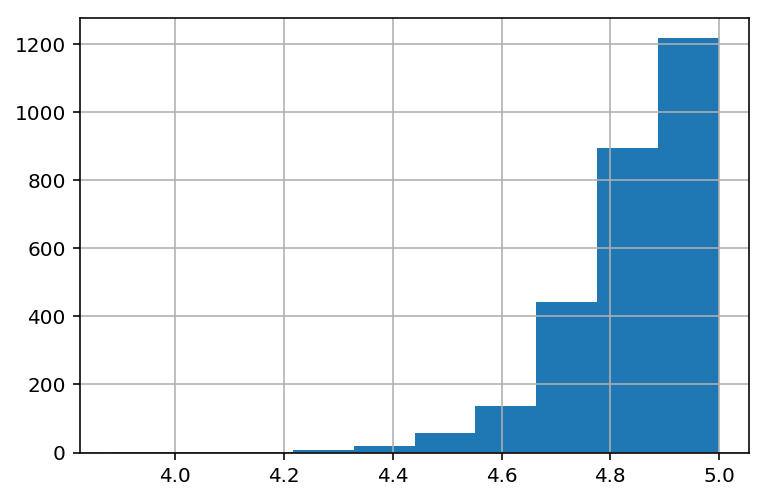

In [69]:
shoppers.rating.hist()

In [70]:
shoppers.isna().sum()

shopper_id         0
seniority          0
found_rate       101
picking_speed      0
accepted_rate     27
rating            84
dtype: int64

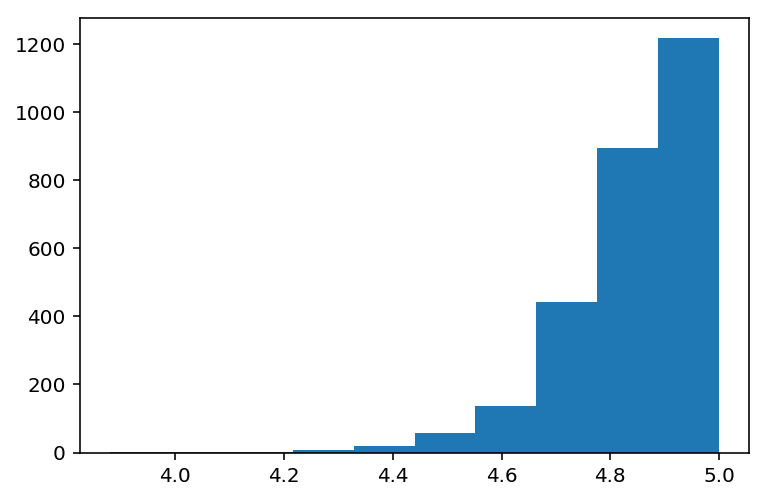

In [71]:
shoppers.rating.hist(grid=False)

In [72]:
shoppers.groupby('seniority').describe()['picking_speed']

,count,mean,std,min,25%,50%,75%,max
seniority,,,,,,,,
41dc7c9e385c4d2b6c1f7836973951bf,440.0,2.239227,0.554820,0.95,2.00,2.22,2.5025,7.04
50e13ee63f086c2fe84229348bc91b5b,719.0,2.272156,0.822574,0.65,1.67,2.17,2.6950,6.11
6c90661e6d2c7579f5ce337c3391dbb9,1643.0,1.392307,0.264627,0.73,1.20,1.37,1.5700,2.00
bb29b8d0d196b5db5a5350e5e3ae2b1f,62.0,2.274032,0.304999,2.00,2.19,2.19,2.1900,3.95


In [73]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy="mean")
shopper_feat_rev = imp.fit_transform(shoppers.set_index('shopper_id')[['found_rate', 'picking_speed', 'accepted_rate', 'rating']])

In [74]:
shopper_feat_rev = pd.DataFrame(shopper_feat_rev, columns=['found_rate_n', 'picking_speed_n', 'accepted_rate_n', 'rating_n'])

In [75]:
shoppers = pd.concat([shoppers, shopper_feat_rev], axis=1)

In [76]:
orders = pd.merge(orders, shoppers, on='shopper_id', how='left')

In [77]:
orders.columns

Index(['order_id', 'lat', 'lng', 'promised_time', 'on_demand', 'shopper_id',
       'store_branch_id', 'total_minutes', 'quantity_conv', 'product_n',
       'product_metcalfe', 'promised_time_hour', 'order_time',
       'order_time_hour', 'order_time_dayofweek', 'is_weekday', 'is_weekend',
       'month', 'dayofmonth', 'destination_point', 'distance', 'seniority',
       'found_rate', 'picking_speed', 'accepted_rate', 'rating',
       'found_rate_n', 'picking_speed_n', 'accepted_rate_n', 'rating_n'],
      dtype='object')

In [78]:
seniority_levels = orders.set_index('order_id').seniority.str.get_dummies()

In [79]:
orders = pd.merge(orders, seniority_levels, on ='order_id', how='left')

In [80]:
shopper_dummies = orders.set_index('order_id').shopper_id.str.get_dummies()

In [81]:
orders['quantity_picking'] = orders['quantity_conv'] / orders['picking_speed']

In [82]:
orders['product_n_picking'] = orders['product_n'] / orders['picking_speed']

### Creating Feature Matrix

In [237]:
feature_matrix = orders[['order_id', 'on_demand', 'quantity_conv', 'order_time_hour', 'is_weekday', 'order_time_dayofweek',
                         'distance', 'is_weekend', 'promised_time_hour', 
       'found_rate_n', 'picking_speed_n', 'accepted_rate_n', 'rating_n',
       '41dc7c9e385c4d2b6c1f7836973951bf', '50e13ee63f086c2fe84229348bc91b5b',
       '6c90661e6d2c7579f5ce337c3391dbb9', 'bb29b8d0d196b5db5a5350e5e3ae2b1f', 'product_n', 'product_metcalfe', 
                         'month', 'dayofmonth', 'quantity_picking', 'product_n_picking']]

In [238]:
feature_matrix = pd.concat([feature_matrix, svd_results], axis=1, ignore_index=True)

In [239]:
feature_matrix.shape

(9978, 33)

In [240]:
feature_matrix.columns = ['order_id', 'on_demand', 'quantity_conv', 'order_time_hour', 'is_weekday', 'order_time_dayofweek',
                         'distance', 'is_weekend', 'promised_time_hour', 
       'found_rate_n', 'picking_speed_n', 'accepted_rate_n', 'rating_n',
       '41dc7c9e385c4d2b6c1f7836973951bf', '50e13ee63f086c2fe84229348bc91b5b',
       '6c90661e6d2c7579f5ce337c3391dbb9', 'bb29b8d0d196b5db5a5350e5e3ae2b1f', 'product_n', 'product_metcalfe', 
                         'month', 'dayofmonth', 'quantity_picking', 'product_n_picking', 'feature_1', 'feature_2', 'feature_3', 
                          'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_10']

In [241]:
orders_predict = orders[orders['total_minutes'].isnull()]

In [242]:
orders_predict.shape

(1995, 36)

In [243]:
orders_predict_ids = orders_predict.order_id.unique()

In [244]:
feature_matrix_model = feature_matrix[~feature_matrix.order_id.isin(orders_predict_ids)]

In [245]:
feature_matrix_model.shape

(7983, 33)

In [246]:
target_model = orders[~orders.order_id.isin(orders_predict_ids)]['total_minutes']

In [247]:
target_model.shape

(7983,)

In [248]:
feature_list = list(feature_matrix_model.columns)

In [233]:
from sklearn.model_selection import train_test_split

In [249]:
train_features, test_features, train_labels, test_labels = train_test_split(feature_matrix_model.set_index('order_id'), target_model, test_size = 0.25, random_state = 42)

In [250]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (5987, 32)
Training Labels Shape: (5987,)
Testing Features Shape: (1996, 32)
Testing Labels Shape: (1996,)


In [251]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 100, max_depth=3, criterion='mae', random_state = 42)
rf.fit(train_features, train_labels)

RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=3,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [252]:
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
print('Median Absolute Error:', round(np.median(errors), 2), 'degrees.')

Mean Absolute Error: 20.86 degrees.
Median Absolute Error: 16.45 degrees.


(array([800., 614., 302., 129.,  67.,  39.,  20.,  16.,   6.,   3.]),
 array([1.05339832e-02, 1.25343661e+01, 2.50581982e+01, 3.75820303e+01,
        5.01058625e+01, 6.26296946e+01, 7.51535267e+01, 8.76773588e+01,
        1.00201191e+02, 1.12725023e+02, 1.25248855e+02]),
 <a list of 10 Patch objects>)

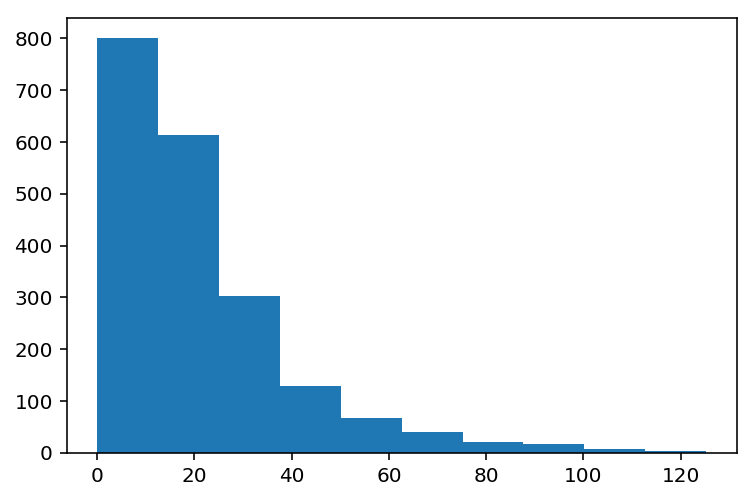

In [253]:
plt.hist(errors)

In [254]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)
# Calculate and display accuracy
avg_mape = np.mean(mape)
print(round(avg_mape, 2), '%.')

27.33 %.


In [255]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: on_demand            Importance: 0.83
Variable: found_rate_n         Importance: 0.11
Variable: order_id             Importance: 0.05
Variable: order_time_dayofweek Importance: 0.02
Variable: quantity_conv        Importance: 0.0
Variable: order_time_hour      Importance: 0.0
Variable: is_weekday           Importance: 0.0
Variable: distance             Importance: 0.0
Variable: is_weekend           Importance: 0.0
Variable: promised_time_hour   Importance: 0.0
Variable: picking_speed_n      Importance: 0.0
Variable: accepted_rate_n      Importance: 0.0
Variable: rating_n             Importance: 0.0
Variable: 41dc7c9e385c4d2b6c1f7836973951bf Importance: 0.0
Variable: 50e13ee63f086c2fe84229348bc91b5b Importance: 0.0
Variable: 6c90661e6d2c7579f5ce337c3391dbb9 Importance: 0.0
Variable: bb29b8d0d196b5db5a5350e5e3ae2b1f Importance: 0.0
Variable: product_n            Importance: 0.0
Variable: product_metcalfe     Importance: 0.0
Variable: month                Importance: 0.0
Variable

### Model 2

In [256]:
from scipy.stats import boxcox
from scipy.special import inv_boxcox

In [264]:
target_n,fitted_lambda = boxcox(target_model, lmbda=None)

In [265]:
feature_list = list(feature_matrix.columns)

In [270]:
train_features, test_features, train_labels, test_labels = train_test_split(feature_matrix_model.set_index('order_id'), target_n, test_size = 0.25, random_state = 42)

In [271]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (5987, 32)
Training Labels Shape: (5987,)
Testing Features Shape: (1996, 32)
Testing Labels Shape: (1996,)


In [272]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 100, max_depth=2, random_state = 42)
# Train the model on training data
rf.fit(train_features, train_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [273]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(inv_boxcox(predictions,fitted_lambda) - inv_boxcox(test_labels,fitted_lambda))
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
print('Median Absolute Error:', round(np.median(errors), 2), 'degrees.')

Mean Absolute Error: 22.06 degrees.
Median Absolute Error: 17.14 degrees.


In [274]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / inv_boxcox(test_labels,fitted_lambda))
# Calculate and display accuracy
avg_mape = np.mean(mape)
print(round(avg_mape, 2), '%.')

29.09 %.


In [275]:
# Scores Train
# Use the forest's predict method on the test data
predictions = rf.predict(train_features)
# Calculate the absolute errors
errors = abs(inv_boxcox(predictions,fitted_lambda) - inv_boxcox(train_labels,fitted_lambda))
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
print('Median Absolute Error:', round(np.median(errors), 2), 'degrees.')

Mean Absolute Error: 22.16 degrees.
Median Absolute Error: 17.63 degrees.


In [276]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / inv_boxcox(train_labels,fitted_lambda))
# Calculate and display accuracy
avg_mape = np.mean(mape)
print(round(avg_mape, 2), '%.')

29.57 %.


### Predicting 

In [277]:
feature_matrix_predict = feature_matrix[feature_matrix.order_id.isin(orders_predict_ids)]

In [278]:
feature_matrix_predict.shape

(1995, 33)

In [301]:
predictions = rf.predict(feature_matrix_predict.set_index('order_id'))

In [302]:
predictions = pd.DataFrame(inv_boxcox(predictions,fitted_lambda), columns=['total_minutes'])

In [303]:
predictions_df = pd.concat([orders_predict.reset_index()['order_id'], predictions], axis=1)

In [305]:
predictions_df.to_csv('predictions.csv')